In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import os
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import json
from torch.utils.data import DataLoader

In [298]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
import numpy as np

class CaseDataset(Dataset):
    def __init__(self, 
                 path,
                 mesure='day',
                 model_type = 'classification',
                 normalize ='max',
                 sensor_idx = 0,
                 drop_year = None,
                 one_year = None):
        self.path = path
        with open(os.path.join(path, 'case_summary.json'), 'r') as f:
                self.case_summary  = json.load(f)
        self.mesure = 'day' # only one implemented.
        self.model_type = model_type
        self.normalize = normalize
        self.sensor_idx = sensor_idx
        self.load_precipitation()
        self.build_data()

    def load_precipitation(self):
        self.precipitation_info = self.case_summary['precipitations']
        self.precip_raw = pd.read_csv(os.path.join(self.path, 
                                                  self.precipitation_info['file']),index_col=[0])
    def build_data(self):
        sensor_raw = self.case_summary['sensors'][self.sensor_idx]['raw'][0] +'_processed.csv'
        sensor_label = self.case_summary['sensors'][self.sensor_idx]['val'][0]+'_processed.csv'
        info = self.case_summary['sensors'][self.sensor_idx]['data_info'][0]
        station_info = self.case_summary['sensors'][self.sensor_idx]['station_info']
        
        df_raw = pd.read_csv(os.path.join(self.path, sensor_raw),index_col=[0])
        df_val = pd.read_csv(os.path.join(self.path, sensor_label),index_col=[0])    
        
        df_raw.rename(columns={'value':'raw'}, inplace = True)
        df_val.rename(columns={'value':'val'}, inplace = True)
        
        df_merge = pd.merge(df_raw, 
                            df_val, 
                            on=['date','year','month','day','hour','minute'], 
                            how='left')
        
#         y.rename(columns={'value':'regression'}, inplace = True)
#         merge = pd.merge(y,X, on=['date', 'year','month','day','hour','minute'], how='left')
#         merge['classification'] = merge.apply(lambda row: 1 if row['regression'] != row['value'] else 0, axis = 1)
#         merge.drop(columns=['value'])
        
        
#         merge['days_in_minutes'] = merge.apply(lambda row: row.hour*60 + row.minute, axis = 1)
#         X['days_in_minutes'] = X.apply(lambda row: row.hour*60 + row.minute, axis = 1)
#         self.y = merge
#         self.X = X
#         if self.mesure == 'day':
#             self.X['sampling'] = self.X.apply(
#                 lambda row: str(row.year) +str(row.month).zfill(2) + str(row.day).zfill(2), 
#                 axis = 1)
#             self.y['sampling'] = self.y.apply(
#                 lambda row: str(row.year) +str(row.month).zfill(2) + str(row.day).zfill(2),
#                 axis = 1)
#         else:
#             print('Method to build data by '+self.mesure + 'is not implemented')
        
#     def __len__(self):
#         return len(self.sampling_index)
    
#     def create_signals(self,idx):
#         inputs = self.X[self.X['sampling'] == self.sampling_index[idx]]
#         inputs = inputs['value'].to_numpy()

#         labels = self.y[self.y['sampling'] == self.sampling_index[idx]]
#         labels = labels[self.model_type].to_numpy()
        
#         if self.normalize == 'max':
#             i_max = np.max(inputs)
#             i_min = np.min(inputs)
            
#             inputs = (inputs - i_min) / (i_max - i_min)
#             if self.model_type == 'regression':
#                 labels = (labels - i_min) / (i_max - i_min)
        
#         if self.model_type == 'regression':
#             labels = np.expand_dims(labels,0)
#         inputs = np.expand_dims(inputs,0)
#         return inputs, labels
    
#     def __getitem__(self, idx):
#         inputs, labels = self.create_signals(idx)
#         inputs = torch.from_numpy(inputs).float()
#         labels = torch.from_numpy(labels).float()
        
#         return inputs, labels

In [281]:
cas = '3'
path = '/home/theaiunicorn/datasets/hackQC2022/cas_'+cas
result_path = '/home/theaiunicorn/datasets/hackQC2022/results/cas_'+cas

In [291]:
dataset = CaseDataset(path, normalize = None, sensor_idx = 1)

In [292]:
x = dataset.X
y = dataset.y
df = pd.DataFrame(list(zip(x['value'],  y['regression'])),
               columns =['value', 'regression'])

In [293]:
df_raw = pd.DataFrame(list(x['value']),
               columns =['value'])
df_raw['indexing'] = np.arange(len(x['value']))
df_val = pd.DataFrame(list(y['regression']),
               columns =['value'])
df_val['indexing'] = np.arange(len(y['regression']))
#df = pd.concat([df_raw,df_val])
df = pd.merge(df_raw,df_val,on='indexing', how='left')
df['validate'] = df.apply(lambda row: row.value_x == row.value_y, axis = 1)

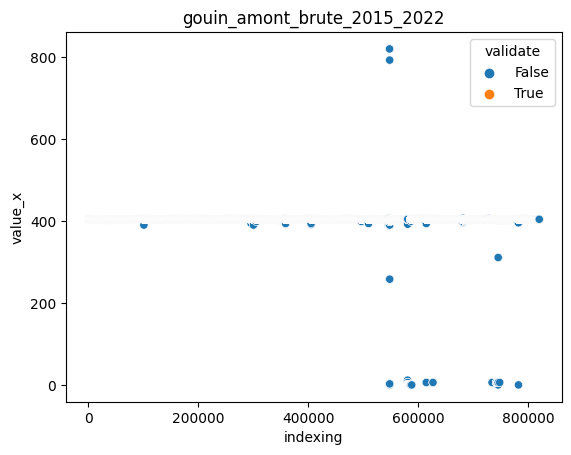

In [294]:
sns.scatterplot(data=df, x="indexing", y="value_x", hue='validate')
plt.title(dataset.case_summary['sensors'][dataset.sensor_idx]['raw'][0])
plt.savefig(os.path.join(result_path,
                        dataset.case_summary['sensors'][dataset.sensor_idx]['raw'][0] + '_raw.png'))

In [295]:
mean_x = np.mean(df.value_x)
std_x = np.std(df.value_x)
df['mean_std_techn'] = df.apply(lambda row: (row.value_x > mean_x - std_x) & (row.value_x < mean_x + std_x), axis = 1)

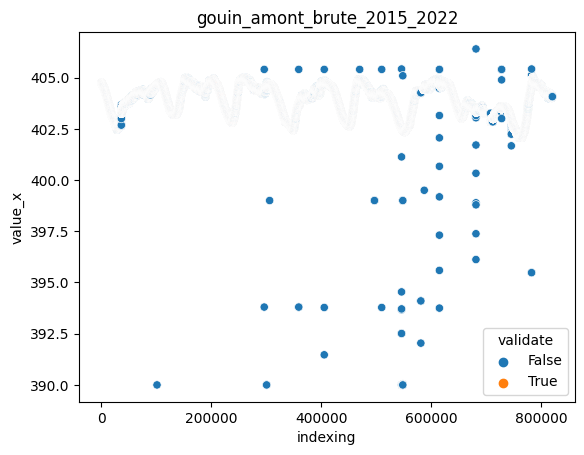

In [296]:
sns.scatterplot(data=df[df['mean_std_techn']==True], x="indexing", y="value_x", hue='validate')
plt.title(dataset.case_summary['sensors'][dataset.sensor_idx]['raw'][0])
plt.savefig(os.path.join(result_path,
                        dataset.case_summary['sensors'][dataset.sensor_idx]['raw'][0] + '_meanstd_removed.png'))

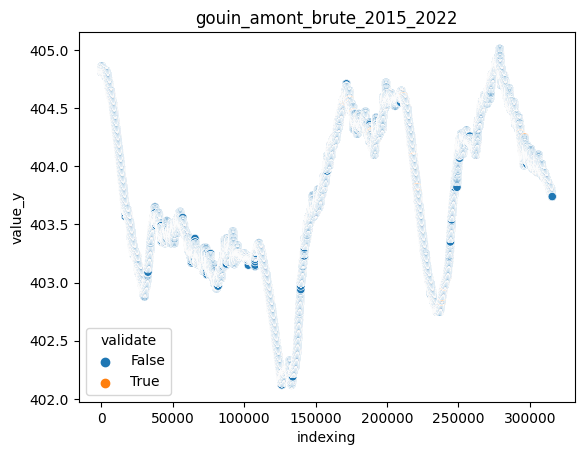

In [297]:
sns.scatterplot(data=df, x="indexing", y="value_y", hue='validate')
plt.title(dataset.case_summary['sensors'][dataset.sensor_idx]['raw'][0])
plt.savefig(os.path.join(result_path,
                        dataset.case_summary['sensors'][dataset.sensor_idx]['raw'][0] + '_validated.png'))

In [2]:
df_raw = pd.read_csv('/home/theaiunicorn/datasets/hackQC2022/cas_1/beauharnois_aval_2007_2015_brutes_processed.csv'
                    ,index_col=[0])
df_val = pd.read_csv('/home/theaiunicorn/datasets/hackQC2022/cas_1/beauharnois_aval_2007_2015_validees_processed.csv'
                    ,index_col=[0])

In [3]:
df_raw.rename(columns={'value':'raw'}, inplace = True)
df_val.rename(columns={'value':'val'}, inplace = True)

In [4]:
df_merge = pd.merge(df_raw, df_val, on=['date','year','month','day','hour','minute'], how='left')

In [5]:
df_merge['raw-val'] = df_merge.apply(lambda row: row.raw - row.val, axis = 1)

In [6]:
df_merge['errors'] = df_merge.apply(lambda row: row['raw-val']!=0, axis = 1)
df_merge['indexing'] = np.arange(len(df_merge['val']))

<AxesSubplot:xlabel='indexing', ylabel='raw'>

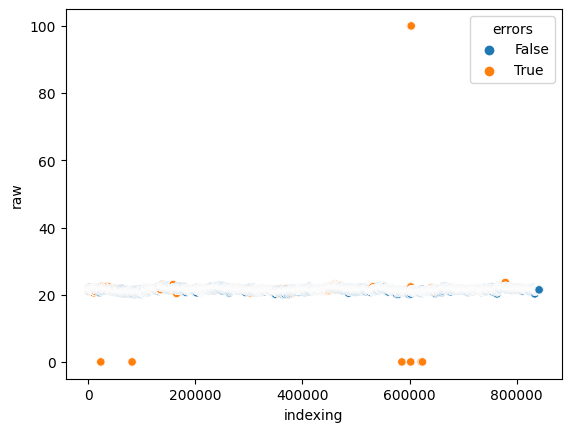

In [7]:
sns.scatterplot(data=df_merge, x="indexing", y="raw", hue='errors')